#### Let's start by calling in all our libraries. I will also initialize a set.seed to make sure that my results are as reproducible as possible.

In [3]:
setwd('/Users/balaji/Documents/Balaji/Coursera/UCI HAR Dataset')
library(glmnet)
library(caret)
library(dplyr)
set.seed(0226)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



#### Let's start by reading in the file with predictors for our training dataset

In [4]:
x.train <- read.table('train/X_train.txt', header=F)

print(paste("The predictor training dataset contains", length(rownames(x.train)),"observations for", 
            length(colnames(x.train)), "variables"))

[1] "This training dataset contains 7352 observations for 561 variables"


#### Are there any missing values in the training predictor dataset? Let's also take a quick look at the dataset.

In [6]:
print(paste("The number of missing values in this dataset is:",sum(is.na(x.train))))
print("Let's take a look at the first 5 rows and columns of the training dataset \n")
x.train[1:5,1:5]

[1] "The number of missing values in this dataset is: 0"
[1] "Let's take a look at the first 5 rows and columns of the training dataset \n"


V1,V2,V3,V4,V5
0.2885845,-0.02029417,-0.1329051,-0.9952786,-0.9831106
0.2784188,-0.01641057,-0.1235202,-0.9982453,-0.9753002
0.2796531,-0.01946716,-0.1134617,-0.9953796,-0.9671870
0.2791739,-0.02620065,-0.1232826,-0.9960915,-0.9834027
0.2766288,-0.01656965,-0.1153619,-0.9981386,-0.9808173


#### We see that the predictors are missing column names. Luckily, these are available in the features.txt file. Let's take a quick look at them 

In [7]:
## These are the names for each of the predictor variables
feat_labels <- read.table('features.txt', row.names = 1, stringsAsFactors = F)
head(feat_labels)

V2
tBodyAcc-mean()-X
tBodyAcc-mean()-Y
tBodyAcc-mean()-Z
tBodyAcc-std()-X
tBodyAcc-std()-Y
tBodyAcc-std()-Z


#### Let's check to see if there are any missing values in this vector. Then we'll check to ensure that the names are all unique. Finally, we'll use 'make.names' to remove the formatting from the names. 

In [8]:
## Any missing values in this vector
print(paste("The number of missing values in the labels vector is", sum(is.na(feat_labels))))

## How many values are unique
print(paste("The number of unique column names are:",length(unique(feat_labels$V2))))

[1] "The number of missing values in the labels vector is 0"
[1] "The number of unique column names are: 477"


#### Looks like only 477/561 values are unique. We can deal with that in the make.names call. We will then assign the unique column names to the training predictors

In [9]:
## Make the feature labels unique by applying the make.names function
feat_labels$V2 <- make.names(feat_labels$V2, unique = T)
## Assign the unique names we created as column names for X.train
colnames(x.train) <- feat_labels$V2

#### Let's now turn our attention to the target variable. Let's read it in, check its dimensions, take a look at its contents, and also check for missing values.

In [5]:
## Read-in the target value for the training dataset
Y.train <- read.table('train/y_train.txt', header=F, col.names = 'target')
print(paste("The target values for the training dataset contains",length(rownames(Y.train)),"observations for",
            length(colnames(Y.train))," variables", "and contains ", length(levels(as.factor(Y.train$target)))," levels"))

cat("The levels of the target values are: \n",levels(as.factor(Y.train$target)))

## Any Missing values in the dataset?
cat(paste("\nThe number of missing values in this dataset is: ",(sum(is.na(Y.train)))))

[1] "The target values for the training dataset contains 7352 observations for 1  variables and contains  6  levels"
The levels of the target values are: 
 1 2 3 4 5 6
The number of missing values in this dataset is:  0

#### We can see that there are 6 levels. What do these numbers stand for? - The answer lies in the 'activity_labels.txt'. Let's take a look at that file and add those values to the target variable df

In [4]:
## Read in the labels for each activity
activity_labels <- read.table('activity_labels.txt',header = F, row.names = 1)

## Add in the Activtiy labels using the mutate function in dplyr
Y.train <- Y.train %>% as_tibble() %>% mutate(target, Activity = ifelse( target %in% 6, "Laying",ifelse( target == 5, "Standing", 
                                          ifelse(target == 4, "Sitting", ifelse(target == 3, "Walking_Downstairs",
                                          ifelse(target == 2, "Walking_Upstairs", "Walking")))))) %>% as.data.frame
cat("Now, our target variable df looks like this: \n")
head(Y.train)

ERROR: Error in eval(lhs, parent, parent): object 'Y.train' not found


#### In a typical real-world situation, we may not have a test dataset to validate our model. This will require partioning our training dataset. Here, I will partition the training dataset (80/20) to ensure that its performance does not deviate significantly from the training dataset to the test dataset. We will then subset our training dataset accordingly.

In [23]:
## Create partitions of the dataset for training/calibration
x.train.ind <- createDataPartition(Y.train$Activity, times = 1, p=0.8, list = F)

## subset the training dataset (and the labels) [The 80% of training set]
train <- x.train[x.train.ind,]
train_labels <- Y.train[x.train.ind,]

## subset the training dataset (and the labels) [The 20% used for calibrating our model]
rem_train <- x.train[-x.train.ind,]
rem_train_labels <- Y.train[-x.train.ind,]

#### Now, we're ready to start the business end of this exercise. We're ready to build a model using our training predictor set. We will be doing this using the glmnet package. We will also generate a plot to assess the output from glmnet

Warning message:
“from glmnet Fortran code (error code -74); Convergence for 74th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”

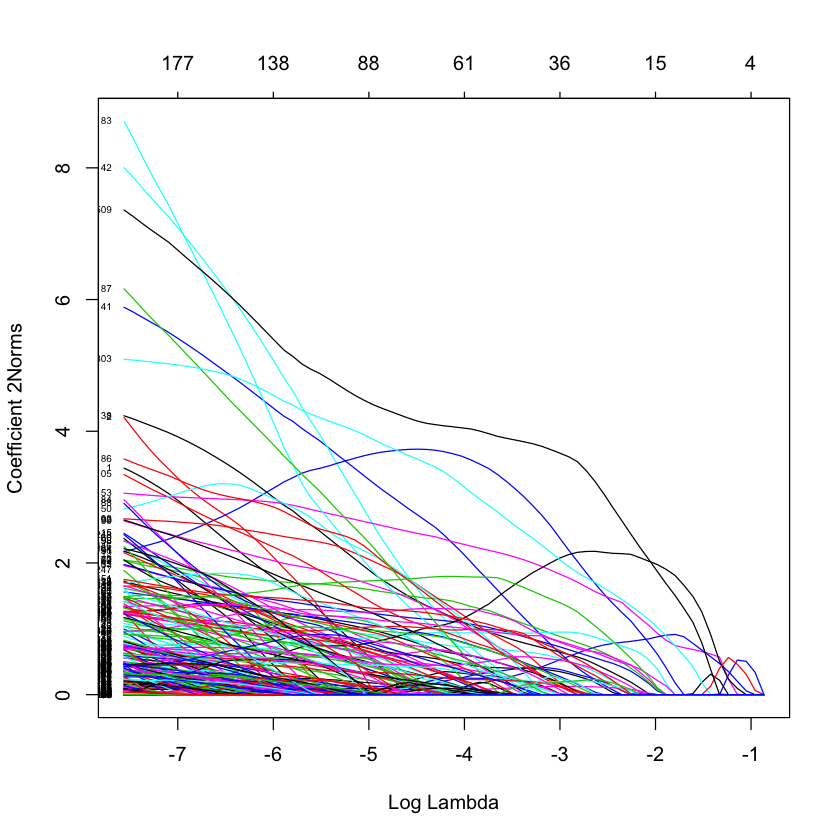

In [25]:
## Since we have a ton of features to predict from, we need to build models and select the features that best predict 
## the target variable
## The glmnet function builds a number of models
testglm <- glmnet(as.matrix(train), train_labels$Activity, family = 'multinomial', type.multinomial = 'grouped')

#### Generate a plot to assess the results from model building
plot(testglm, xvar = "lambda", label = TRUE, type.coef = "2norm")

#### The plot above tells us that as lambda decreases (right to left), the model's reliance on certain feature increases - a sign of overfitting to the training dataset. log lambda vs fraction deviance is another good way to assess model performance across the range of lambda.

Now that glmnet has generated multiple models of the training dataset that best explain our target variable. Let's perform a 10-fold cross-validation to select the best lambda that explains our model.

Loading required package: doMC
Loading required package: iterators
Loading required package: parallel


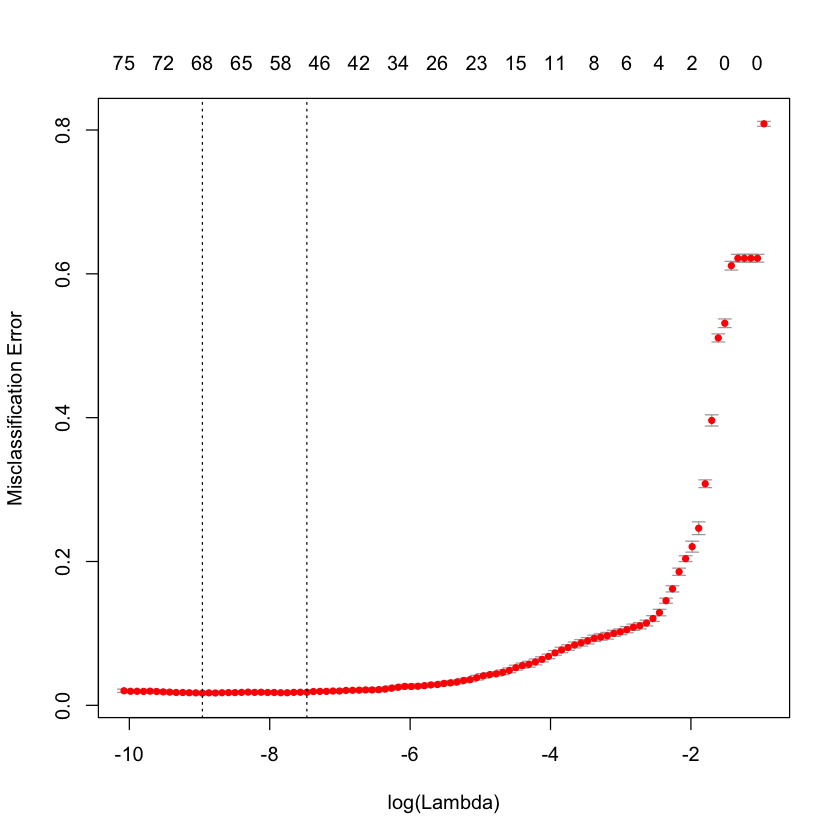

In [26]:
## Perform Cross-validation to find the features with the lowest error values
require(doMC)
registerDoMC(cores = 8)
glm.fit <- cv.glmnet(as.matrix(train), train_labels$Activity, family = 'multinomial',
                     type.measure = 'class', nfolds = 10, parallel = T)

## Let's visualize the results of our cross-validation 
plot(glm.fit)

#### A quick look at the plot (from left to right) shows the lowest lambda and one standard error of the lambda. We will use one-standard error of the lambda to predict the 20% of the training dataset that we had sliced off earlier.
* The reason we use one standard error of the lambda is because lambda.min tends to 'shift' every time this making the model rigid. On the other hand, the lambda.1se preserves the ability of the model to remain flexible.
* We will initiate the prediction call with 'type = class', so we get factor predictions (laying, standing, etc..)
We will then compare the predicted findings to the target values

In [28]:
## Let's use the model we just created to make predictions for the 20% we set aside for calibrating our model
rem.pred <- predict(glm.fit, s = "lambda.1se", newx = as.matrix(rem_train), type = 'class')
confusionMatrix(rem.pred, rem_train_labels$Activity)

Confusion Matrix and Statistics

                    Reference
Prediction           Laying Sitting Standing Walking Walking_Downstairs
  Laying                281       0        0       0                  0
  Sitting                 0     252        8       0                  0
  Standing                0       4      265       0                  0
  Walking                 0       1        1     245                  0
  Walking_Downstairs      0       0        0       0                196
  Walking_Upstairs        0       0        0       0                  1
                    Reference
Prediction           Walking_Upstairs
  Laying                            0
  Sitting                           0
  Standing                          0
  Walking                           0
  Walking_Downstairs                0
  Walking_Upstairs                214

Overall Statistics
                                          
               Accuracy : 0.9898          
                 95% CI : (0.98

### Finally, we read in the test dataset, add in the activity labels, make predictions and compare them to the predicted results. 

In [29]:
## Read in the test x values
x.test <- read.table('test/X_test.txt')

## Read in the tesy y values
Y.test <- read.table('test/y_test.txt', header=F, col.names = 'target') 

## Add in the Activtiy labels using the mutate function in dplyr
Y.test <- Y.test %>% as_tibble() %>% mutate(target, Activity = ifelse( target %in% 6, "Laying",ifelse( target == 5, "Standing", 
                                            ifelse(target == 4, "Sitting", ifelse(target == 3, "Walking_Downstairs",
                                            ifelse(target == 2, "Walking_Upstairs", "Walking")))))) %>% as.data.frame

## Finally, predict the test values and calculate the accuracy of that prediction
test.pred <- predict(glm.fit, s='lambda.1se', newx=as.matrix(x.test), type='class')
confusionMatrix(test.pred, Y.test$Activity)

Confusion Matrix and Statistics

                    Reference
Prediction           Laying Sitting Standing Walking Walking_Downstairs
  Laying                533       0        0       0                  0
  Sitting                 0     432       18       0                  0
  Standing                4      56      513       0                  0
  Walking                 0       0        1     492                  5
  Walking_Downstairs      0       0        0       2                392
  Walking_Upstairs        0       3        0       2                 23
                    Reference
Prediction           Walking_Upstairs
  Laying                            0
  Sitting                           0
  Standing                          0
  Walking                          34
  Walking_Downstairs                4
  Walking_Upstairs                433

Overall Statistics
                                          
               Accuracy : 0.9484          
                 95% CI : (0.93